In [5]:
!tree -dL 2 input/

input/

0 directories


In [6]:
# generic librairies
import time as time
import numpy as np
import pandas as pd
import gc

# Text librairies
import re
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tag.util import untag
import contractions
# import pycontractions # Alternative better package for removing contractions
from autocorrect import Speller


from IPython.display import set_matplotlib_formats, display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
#plt.rc('axes', prop_cycle=(
#    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
#    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']

# Load Data

In [7]:
%%time

# https://numpy.org/devdocs/user/basics.types.html

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str', 'Body': 'str', 'Text': 'str'}

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=['Id', 'Score', 'Title', 'Body','Text'], 
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=10000
                          )

ValueError: Usecols do not match columns, columns expected but not found: ['Score', 'Body', 'Id', 'Text', 'Title']

In [8]:
df_questions

NameError: name 'df_questions' is not defined

In [ ]:
text_train = df_questions.Text
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[6]:\n{}".format(text_train[6]))

# Representer le texte en "Bag of Words"

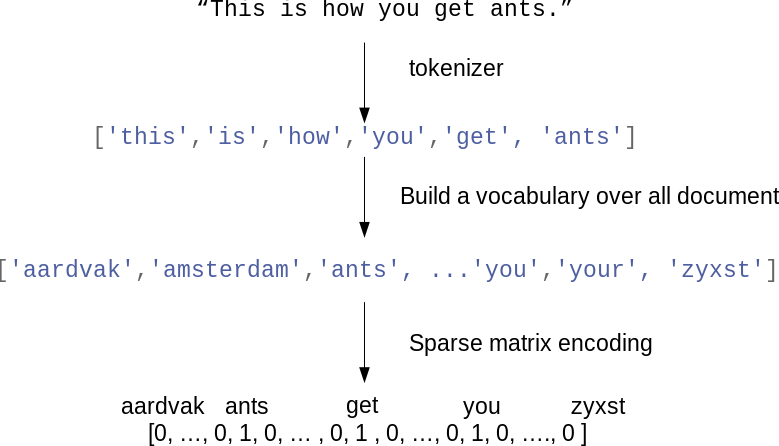

In [ ]:
# faire un test de bag of words

bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

In [ ]:
print("Vocabulary size: {}".format(len(vect.vocabulary_)))
print("Vocabulary content:\n {}".format(vect.vocabulary_))

In [ ]:
bag_of_words = vect.transform(bards_words)
print("bag_of_words: {}".format(repr(bag_of_words)))

In [ ]:
print("Dense representation of bag_of_words:\n{}".format(
    bag_of_words.toarray()))

## bag-of-words de Post

In [ ]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n{}".format(repr(X_train)))

In [ ]:
feature_names = vect.get_feature_names()
print("Number of features: {}".format(len(feature_names)))
print("First 20 features:\n{}".format(feature_names[:20]))
print("Features 5010 to 5030:\n{}".format(feature_names[5010:5030]))
print("Every 2000th feature:\n{}".format(feature_names[::2000]))

## bag-ofword avec plus d'un mot (n-grams)

In [ ]:
print("bards_words:\n{}".format(bards_words))

In [ ]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

In [ ]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

In [ ]:
print("Transformed data (dense):\n{}".format(cv.transform(bards_words).toarray()))

In [ ]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("Vocabulary size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

# Modélisation automatique des sujets

## LDA, Latent Dirichlet Allocation
L'objectif de ce type de modélisation de sujets est de récupérer de potentielles catégories pour des traitements ultérieurs. Cette modélisation offre surtout une meilleure compréhension de la structuration du texte en vue de création de features manuelles (mettre l'accent sur certains mots, comprendre ce qui définit une catégorie, etc.)


In [ ]:
vect = CountVectorizer(max_features=10000, max_df=.15)
X = vect.fit_transform(text_train)

max_df : float in range [0.0, 1.0] or int, default=1.0
    When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold (corpus-specific
    stop words).

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10,
                                learning_method="online",
                                learning_offset=50.,
                                max_iter=25,
                                random_state=0)
# We build the model and transform the data in one step
# Computing transform takes some time,
# and we can save time by doing both at once
document_topics = lda.fit_transform(X)

In [ ]:
print("lda.components_.shape: {}".format(lda.components_.shape))

In [ ]:
# for each topic (a row in the components_), sort the features (ascending).
# Invert rows with [:, ::-1] to make sorting descending
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# get the feature names from the vectorizer:
feature_names = np.array(vect.get_feature_names())

In [ ]:
#fonction du livre introduction_to_ml_with_python-master

def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")

In [ ]:
# Print out the 10 topics:

print_topics(topics=range(10), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

In [ ]:
lda100 = LatentDirichletAllocation(n_components=100, learning_method="batch",
                                   max_iter=25, random_state=0)
document_topics100 = lda100.fit_transform(X)

In [ ]:
topics = np.array([2,7, 16, 24, 25, 28, 36, 37, 41, 45, 51, 53, 54, 63, 89, 97])

In [ ]:
sorting = np.argsort(lda100.components_, axis=1)[:, ::-1]
feature_names = np.array(vect.get_feature_names())
print_topics(topics=topics, feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=8, n_words=10)

In [ ]:
# sort by weight of "function" topic 36
function = np.argsort(document_topics100[:, 63])[::-1]
# print the five documents where the topic is most important
for i in function[:5]:
    # show first two sentences
    print(".".join(text_train[i].split(".")[:2]) + ".\n")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]
# two column bar chart:
for col in [0, 1]:
    start = col * 50
    end = (col + 1) * 50
    ax[col].barh(np.arange(50), np.sum(document_topics100, axis=0)[start:end])
    ax[col].set_yticks(np.arange(50))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top")
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 25)
    ax[col].patch.set_facecolor('#ababab')
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)
plt.tight_layout()
fig.patch.set_facecolor('w')

## NMF - Negative Matrix Factorisation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
    min_df=2, 
    max_features=no_features, 
    stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(text_train)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf)

no_top_words = 5
#display_topics(nmf, tfidf_feature_names, no_top_words)

sorting_nmf = np.argsort(nmf.components_, axis=1)[:, ::-1]
print_topics(topics=range(20), feature_names=tfidf_feature_names,
                           sorting=sorting_nmf, topics_per_chunk=8, n_words=10)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join(
            [feature_names[i] for i in topic.argsort()[::-1][:no_top_words]]))

display_topics(nmf, tfidf_feature_names, no_top_words)